# Detecting DOS attacks and detection rate using python

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

import sys
import asyncio 

if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())


In [2]:
data = pd.read_csv('dataset.csv')

## Analzying dataset

In [3]:
data.head()

,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket
0,0,38.57.146.249,True,12,notification,2022-01-02T03:31:34.498Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
1,1,55.220.132.116,True,12,notification,2022-01-02T03:54:53.136Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
2,2,141.232.38.48,True,12,notification,2022-01-02T03:38:31.950Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
3,3,228.143.56.163,True,12,notification,2022-01-02T03:44:36.548Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
4,4,223.113.21.186,True,12,notification,2022-01-02T03:52:54.326Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0


In [4]:
data.shape

(187087, 19)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187087 entries, 0 to 187086
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Id                         187087 non-null  int64  
 1   IP                         187087 non-null  object 
 2   bot                        187087 non-null  bool   
 3   FunctionId                 187087 non-null  int64  
 4   functionTrigger            187087 non-null  object 
 5   timestamp                  187087 non-null  object 
 6   SubmitTime                 187087 non-null  int64  
 7   RTT                        187087 non-null  int64  
 8   InvocationDelay            187087 non-null  float64
 9   ResponseDelay              187087 non-null  float64
 10  FunctionDuration           187087 non-null  float64
 11  ActiveFunctionsAtRequest   187087 non-null  int64  
 12  ActiveFunctionsAtResponse  187087 non-null  int64  
 13  maxcpu                     18

In [6]:
# Here the data levels are observed to contain boolean values: False - Legitimate, True-Maliciuous 
data.bot.unique()

array([ True, False])

In [7]:
data.bot.value_counts()

True     131072
False     56015
Name: bot, dtype: int64

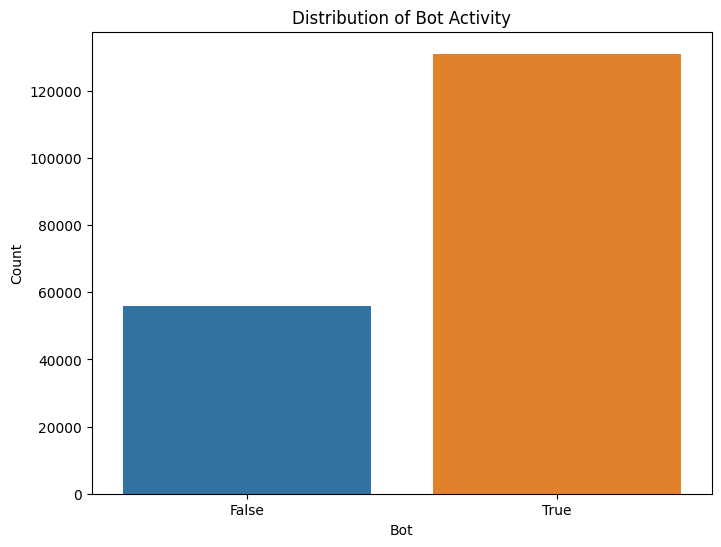

In [8]:
# Bar chart of bot activity
plt.figure(figsize=(8, 6))
sns.countplot(x='bot', data=data)
plt.title('Distribution of Bot Activity')
plt.xlabel('Bot')
plt.ylabel('Count')
plt.show()

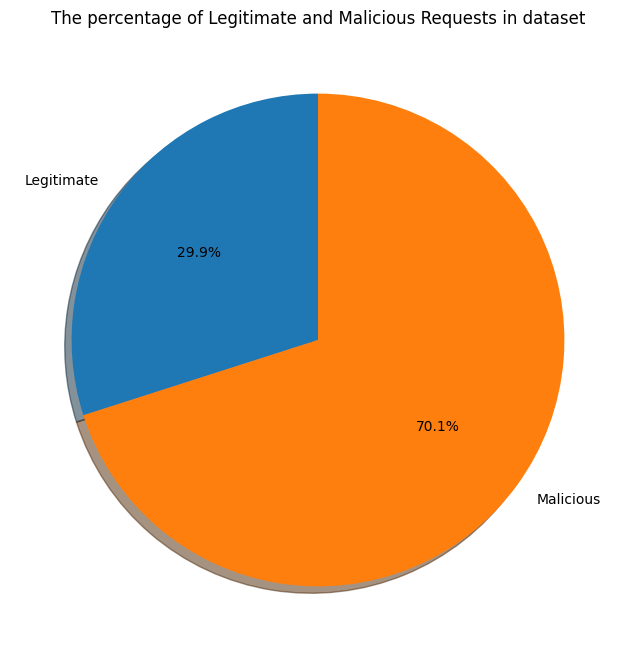

In [9]:
labels = ["Legitimate", "Malicious"]  # Corrected order of labels
sizes = [data['bot'].value_counts()[False], data['bot'].value_counts()[True]]  # Corrected calculation

plt.figure(figsize=(13, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('The percentage of Legitimate and Malicious Requests in dataset')
plt.show()


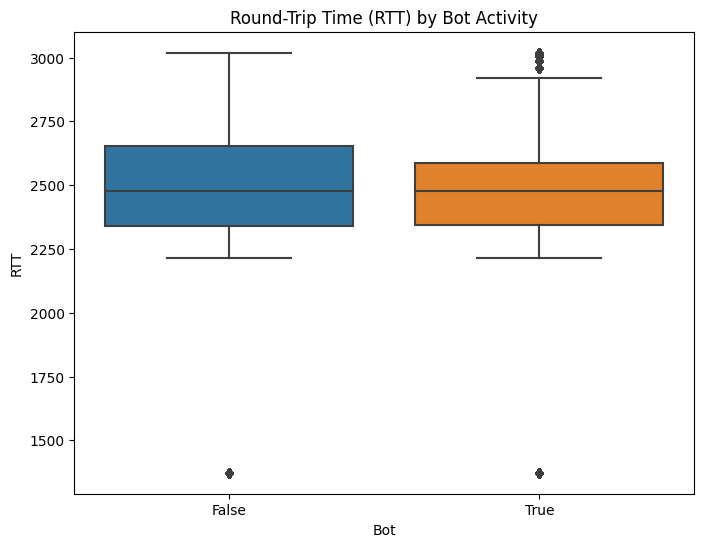

In [10]:
# Box plot of traffic volume by bot activity
plt.figure(figsize=(8, 6))
sns.boxplot(x='bot', y='RTT', data=data)
plt.title('Round-Trip Time (RTT) by Bot Activity')
plt.xlabel('Bot')
plt.ylabel('RTT')
plt.show()

C:\Users\fiado\AppData\Local\Temp\ipykernel_7776\2067643080.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr()[['bot']].sort_values(by='bot', ascending=False), annot=True, cmap='coolwarm')


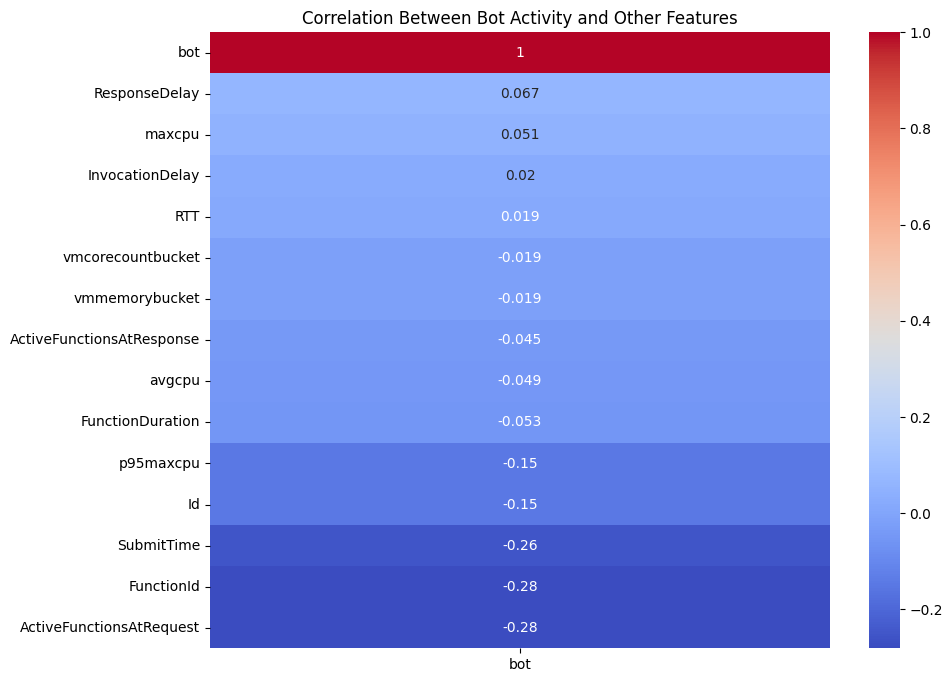

In [11]:
# Heatmap of correlation between bot activity and other features
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr()[['bot']].sort_values(by='bot', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation Between Bot Activity and Other Features')
plt.show()

In [12]:
data.describe()

,Id,FunctionId,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcorecountbucket,vmmemorybucket
count,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000
mean,93543.000000,28.592569,85.841250,2494.167083,1239.287586,165.658396,1089.373666,28.592569,996.465741,97.050470,31.440571,88.441047,4.776297,31.000653
std,54007.509243,13.777358,11.968575,286.236688,299.874337,42.838260,62.326101,13.777358,3.010734,5.018163,17.386644,20.042926,3.489087,27.057633
min,0.000000,2.000000,71.000000,1373.000000,170.746338,117.803711,1031.168938,2.000000,988.000000,78.776399,1.350084,7.924250,1.000000,0.750000
25%,46771.500000,17.000000,75.000000,2344.000000,1060.574707,134.759521,1059.582233,17.000000,994.000000,96.017207,19.830185,89.853209,1.000000,1.750000
50%,93543.000000,30.000000,79.000000,2476.000000,1205.249512,145.178711,1074.904203,30.000000,998.000000,99.356190,33.304020,95.297275,8.000000,56.000000
75%,140314.500000,40.000000,98.000000,2593.000000,1388.304443,203.505127,1099.621534,40.000000,999.000000,99.566656,41.804117,98.110481,8.000000,56.000000
max,187086.000000,50.000000,102.000000,3019.000000,1800.190674,247.116455,1437.139511,50.000000,999.000000,100.000000,92.503412,99.586511,8.000000,56.000000


Text(0.5, 1.0, 'Features which has NuLL values')

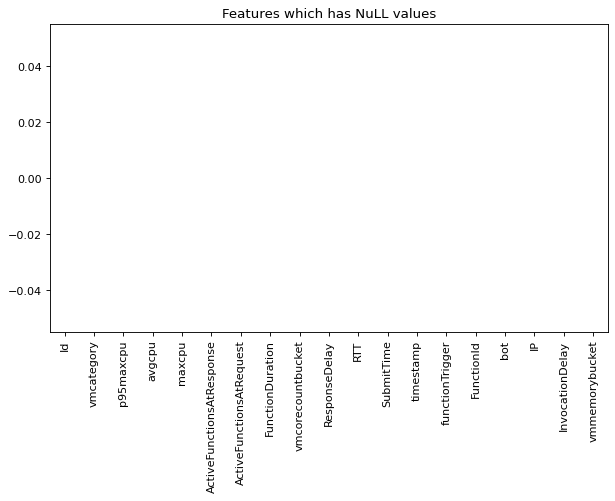

In [13]:
# Vizualisation of Null valued features
figure(figsize=(9, 5), dpi=80)
data[data.columns[data.isna().sum() >= 0]].isna().sum().sort_values().plot.bar()
plt.title("Features which has NuLL values")

In [14]:
data.isnull().sum()

Id                           0
IP                           0
bot                          0
FunctionId                   0
functionTrigger              0
timestamp                    0
SubmitTime                   0
RTT                          0
InvocationDelay              0
ResponseDelay                0
FunctionDuration             0
ActiveFunctionsAtRequest     0
ActiveFunctionsAtResponse    0
maxcpu                       0
avgcpu                       0
p95maxcpu                    0
vmcategory                   0
vmcorecountbucket            0
vmmemorybucket               0
dtype: int64

In [15]:

numeric_df = data.select_dtypes(include=['int64', 'float64'])
object_df = data.select_dtypes(include=['object'])
numeric_cols = numeric_df.columns
object_cols = object_df.columns
print('Numeric Columns: ')
print(numeric_cols, '\n')
print('Object Columns: ')
print(object_cols, '\n')
print('Number of Numeric Features: ', len(numeric_cols))
print('Number of Object Features: ', len(object_cols))

Numeric Columns: 
Index(['Id', 'FunctionId', 'SubmitTime', 'RTT', 'InvocationDelay',
       'ResponseDelay', 'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object') 

Object Columns: 
Index(['IP', 'functionTrigger', 'timestamp', 'vmcategory'], dtype='object') 

Number of Numeric Features:  14
Number of Object Features:  4


In [16]:
object_df.head()

,IP,functionTrigger,timestamp,vmcategory
0,38.57.146.249,notification,2022-01-02T03:31:34.498Z,Delay-insensitive
1,55.220.132.116,notification,2022-01-02T03:54:53.136Z,Delay-insensitive
2,141.232.38.48,notification,2022-01-02T03:38:31.950Z,Delay-insensitive
3,228.143.56.163,notification,2022-01-02T03:44:36.548Z,Delay-insensitive
4,223.113.21.186,notification,2022-01-02T03:52:54.326Z,Delay-insensitive


In [17]:
# Counting the number of requests per IP address
requests_per_ip = data['IP'].value_counts()

# Displaying the count for each IP address
print(requests_per_ip)


158.135.184.38    2159
190.50.77.86      2155
142.45.98.176     2070
227.200.85.209    1800
84.243.175.245    1800
                  ... 
204.99.250.152       1
38.250.139.62        1
214.88.87.14         1
211.253.165.77       1
58.147.76.78         1
Name: IP, Length: 7587, dtype: int64


In [18]:
requests_per_ip.head(150)

158.135.184.38     2159
190.50.77.86       2155
142.45.98.176      2070
227.200.85.209     1800
84.243.175.245     1800
                   ... 
6.235.225.120         9
246.18.196.15         9
81.100.115.207        9
50.59.151.158         9
243.134.193.194       9
Name: IP, Length: 150, dtype: int64

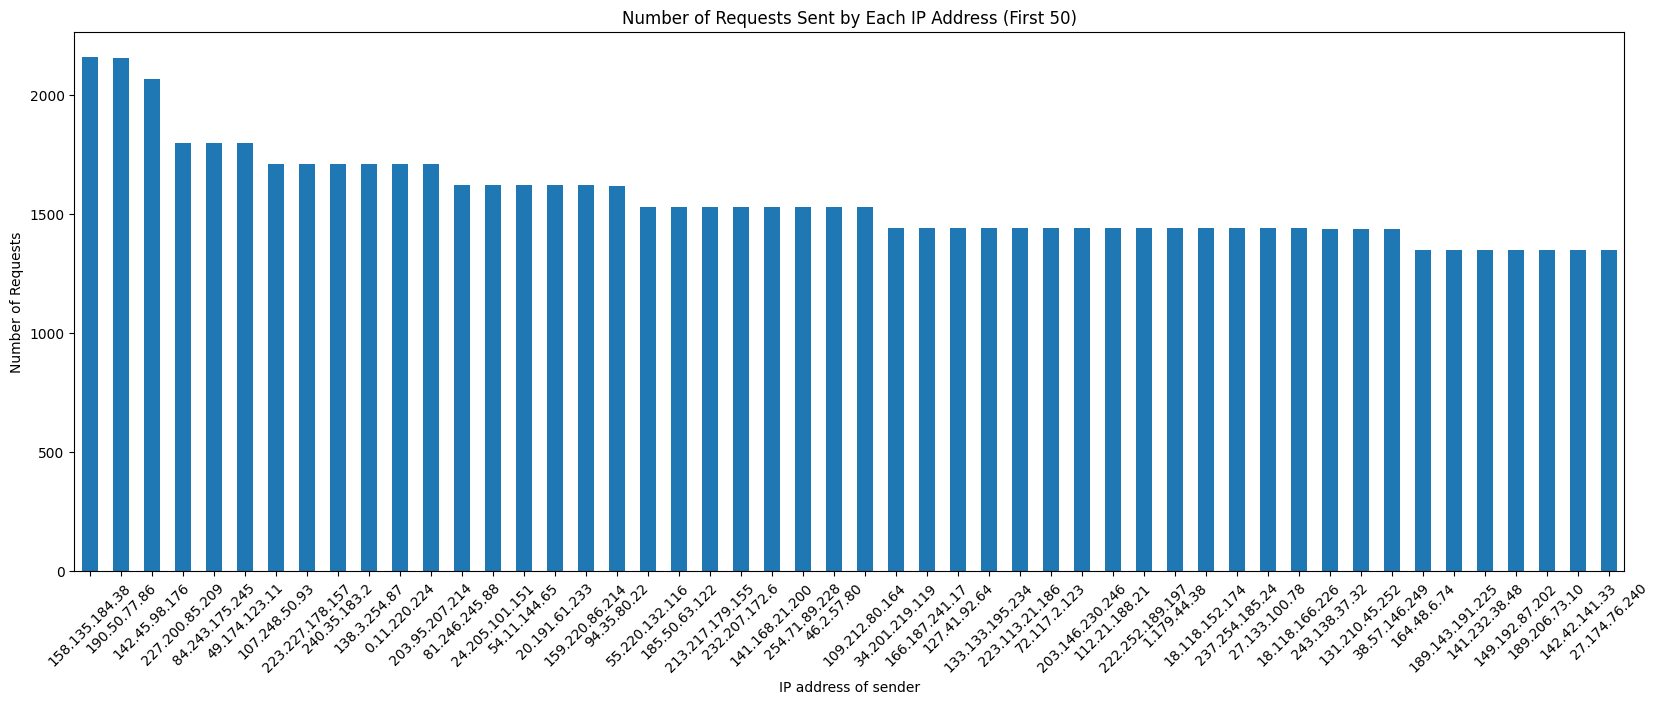

In [30]:
# Selecting the first 50 entries of requests_per_ip
requests_per_ip_subset = requests_per_ip.head(50)

# Plot the counts of requests for the first 50 IP addresses
plt.figure(figsize=(20, 7))
requests_per_ip_subset.plot(kind='bar')
plt.xlabel('IP address of sender')
plt.ylabel('Number of Requests')
plt.title('Number of Requests Sent by Each IP Address (First 50)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [20]:
# Number of attack requests by each IP bot address
subset_data = data[data['bot'] == True]['IP'].value_counts()
print(subset_data)


158.135.184.38     2159
190.50.77.86       2155
142.45.98.176      2070
84.243.175.245     1800
227.200.85.209     1800
                   ... 
212.133.126.132     720
206.191.90.105      711
43.198.161.62       630
40.57.198.164       360
46.240.71.108       270
Name: IP, Length: 100, dtype: int64


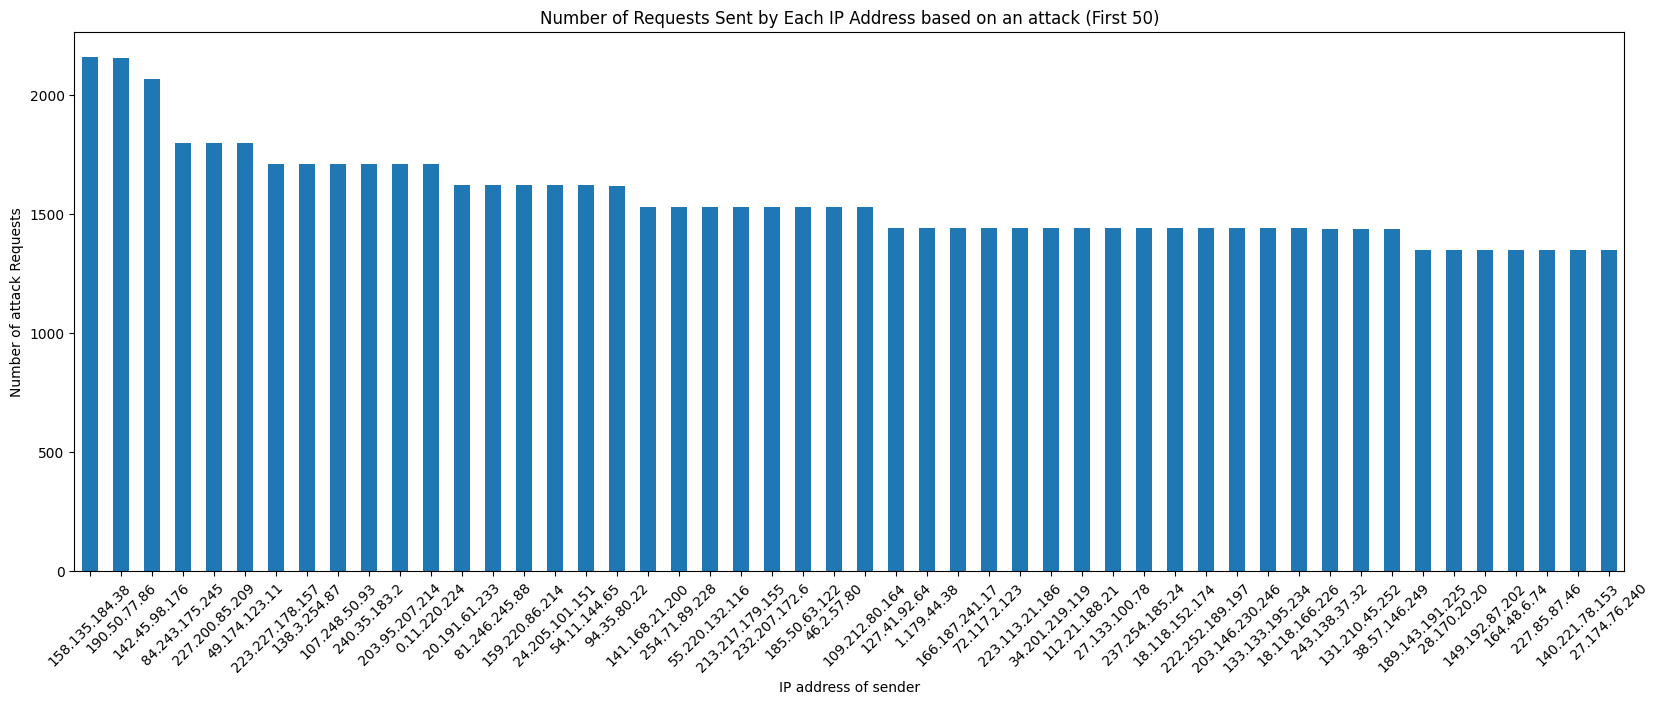

In [31]:
# Selecting the first 50 entries of requests_per_ip
subset_data_trun = subset_data.head(50)

plt.figure(figsize=(20, 7))
subset_data_trun.plot(kind='bar')
plt.xlabel('IP address of sender')
plt.ylabel('Number of attack Requests')
plt.title('Number of Requests Sent by Each IP Address based on an attack (First 50)')
plt.xticks(rotation=45) 
plt.show()


In [22]:
data.columns

Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object')

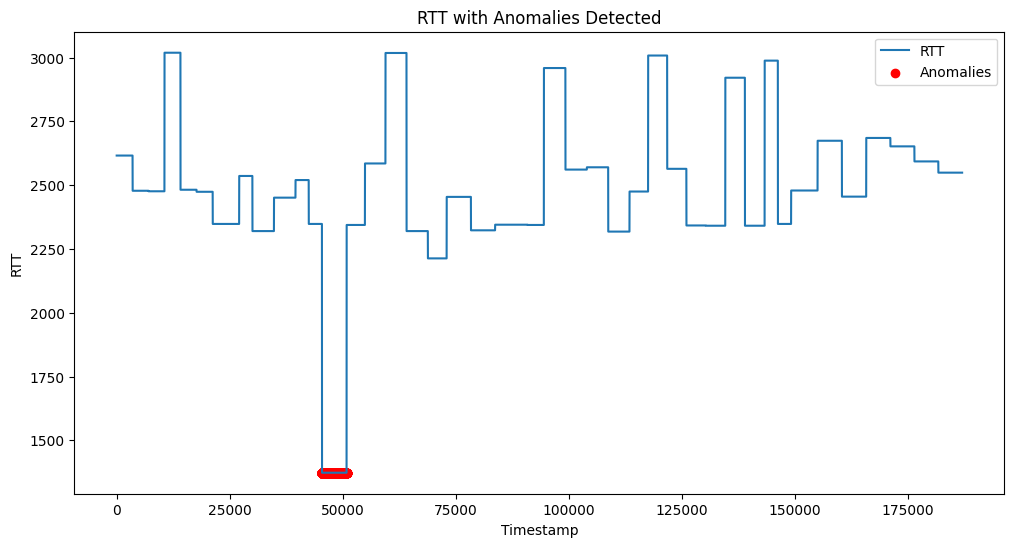

In [23]:
# Step 3: Anomaly Detection
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest model
model = IsolationForest(contamination=0.05)
model.fit(data[['RTT']])

# Predict anomalies
anomalies = model.predict(data[['RTT']])

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['RTT'], label='RTT')
plt.scatter(data.index[anomalies == -1], data['RTT'][anomalies == -1], color='red', label='Anomalies')
plt.title('RTT with Anomalies Detected')
plt.xlabel('Timestamp')
plt.ylabel('RTT')
plt.legend()
plt.show()

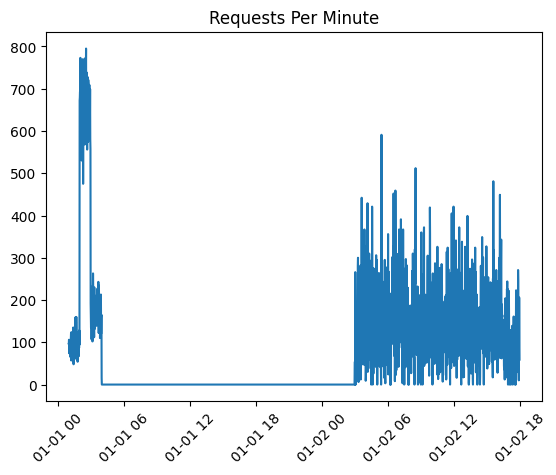

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'timestamp' column to datetime type
data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True)

# Floor the 'timestamp' to the nearest minute
data['minute'] = data['timestamp'].dt.floor('1T')

# Set the 'minute' column as the index
data = data.set_index('minute')
 
# Group data by minute and count the number of requests per minute
rpm = data.groupby(pd.Grouper(freq='1T')).count()['IP']

# Plot Requests Per Minute (RPM)
plt.plot(rpm)
plt.title('Requests Per Minute')
plt.xticks(rotation=45)
plt.show()


Series([], Freq: T, Name: IP, dtype: int64)


C:\Users\fiado\AppData\Local\Temp\ipykernel_7776\2129838644.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,anomaly_score
minute,,,,,,,,,,,,,,,,,,,,


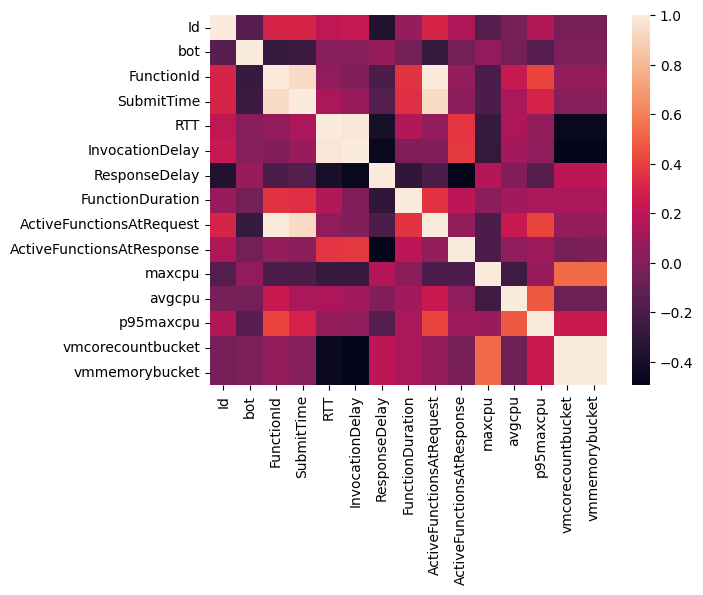

In [25]:
# Anomaly detection
rpm_model = IsolationForest(n_estimators=100)
rpm_model.fit(rpm.values.reshape(-1,1))
rpm_scores = rpm_model.decision_function(rpm.values.reshape(-1,1))  
rpm_anoms = rpm[rpm_scores < -0.5]
print(rpm_anoms)

# Correlation analysis
corr = data.corr()  
sns.heatmap(corr)

# Anomaly detection
X = data[['FunctionDuration','avgcpu']]
clf = IsolationForest(n_estimators=100)
clf.fit(X)
data['anomaly_score'] = clf.decision_function(X) 
data[data['anomaly_score'] < -0.5]

In [26]:
# Feature engineering and classification (using scikit-learn as an example)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Numeric columns
numeric_columns = ['Id', 'FunctionId', 'SubmitTime', 'RTT', 'InvocationDelay',
                   'ResponseDelay', 'FunctionDuration', 'ActiveFunctionsAtRequest',
                   'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
                   'vmcorecountbucket', 'vmmemorybucket']

# Object columns
object_columns = ['IP', 'functionTrigger', 'timestamp', 'vmcategory']

# Assuming you have features ready and stored in 'X' and labels in 'y'
# Replace 'X' and 'y' with your actual feature and label variables
X_train, X_test, y_train, y_test = train_test_split(data[numeric_columns], data['bot'], test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

C:\Users\fiado\AppData\Local\Temp\ipykernel_7776\1685909457.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resource_utilization = data.groupby(data.index).mean()[['avgcpu', 'vmmemorybucket']]


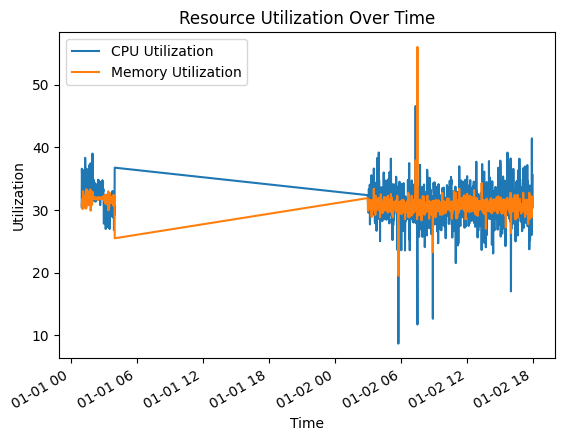

In [27]:
# Resource utilization analysis
resource_utilization = data.groupby(data.index).mean()[['avgcpu', 'vmmemorybucket']]

# Plot resource utilization over time
resource_utilization.plot()
plt.title('Resource Utilization Over Time')
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.legend(['CPU Utilization', 'Memory Utilization'])
plt.show()


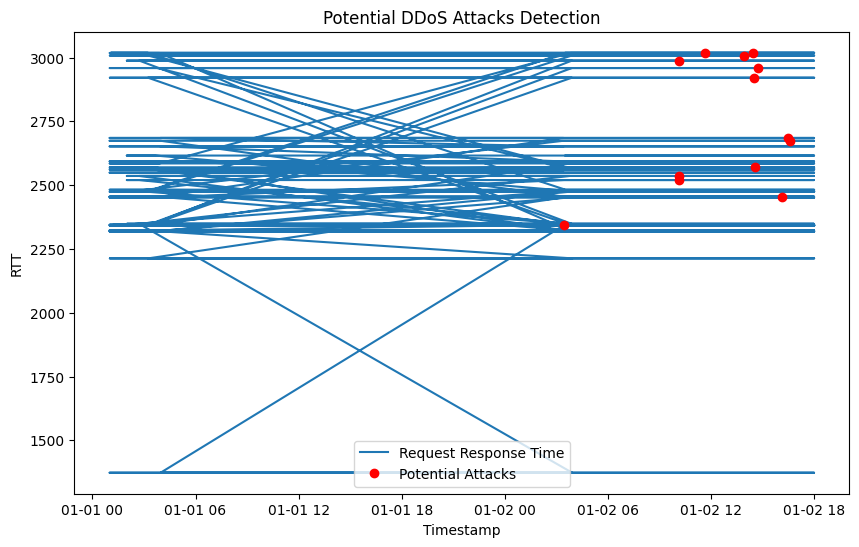

In [28]:
# Security analysis: Detect potential DDoS attacks based on request patterns
from scipy.signal import find_peaks

# Find peaks in request volume
threshold = 100  # Adjust threshold as needed
distance = 10  # Adjust distance as needed
peaks, _ = find_peaks(data['RTT'], height=threshold, distance=distance)

# Identify potential DDoS attacks
potential_attacks = data.iloc[peaks]

# Visualize potential DDoS attacks
plt.figure(figsize=(10, 6))
plt.plot(data['timestamp'], data['RTT'], label='Request Response Time')
plt.plot(potential_attacks['timestamp'], potential_attacks['RTT'], 'ro', label='Potential Attacks')
plt.title('Potential DDoS Attacks Detection')
plt.xlabel('Timestamp')
plt.ylabel('RTT')
plt.legend()
plt.show()